In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import chexmix.table.utils as tb
from chexmix.utils import data_file

## 1. chexmix query by targets

In [20]:
%%time

#targets is List of target name
targets = ['pparg']
# targets = ['lupus erythematosus', 'pparg', 'ppara', 'lxr', 'rxr', 'arg1', 'scd1', 'pd-l1', 'tslp', 'jak']
total_year_count = None

#make entity dataframe by targets
for keyword in targets:
    pm_table = tb.search_by_keyword(keyword)

    gene_df = pd.DataFrame([(v.id, v.name) for v in pm_table.values() if v.id[:4] == 'GENE'], columns=('id', 'name'))
    meshs = [v for v in pm_table.values() if v.id[:3] == 'MSH']
    disease_df = pd.DataFrame([(mesh.id, mesh.name) for mesh in meshs if mesh.is_disease()], columns=('id', 'name'))
    chemical_df = pd.DataFrame([(mesh.id, mesh.name) for mesh in meshs if not mesh.is_disease()], columns=('id', 'name'))

    pubs = [v for v in pm_table.values() if v.id[:4] == 'ARTI']
    pub_rel_df = pd.DataFrame([(pub.id, entity, pd.to_datetime(pub.history['pubmed'][0][:10])) for pub in pubs for entity in pub.extra_relationship['_APPEARED_IN']], columns=('pub_id', 'id', 'date'))
    pub_df = pd.DataFrame([(v.id, v.source, v.issue, pd.to_datetime(v.history['pubmed'][0][:10])) for v in pubs], columns=('id', 'source', 'issue', 'date'))
    pub_rel_df['year'] = pub_rel_df['date'].dt.year
    pub_rel_df['month'] = pub_rel_df['date'].dt.month
    pub_df['year'] = pub_df['date'].dt.year
    pub_df['month'] = pub_df['date'].dt.month

    pub_chemical_df = pd.merge(chemical_df, pub_rel_df, on='id', how='left')
    pub_dis_df = pd.merge(disease_df, pub_rel_df, on='id', how='left')
    pub_gene_df = pd.merge(gene_df, pub_rel_df, on='id', how='left')

    #total chemical, disease, gene count yearly by keyword
    chemical_count = pub_chemical_df.groupby(['id', 'name', 'year']).size().reset_index().sort_values(by=[0], ascending=False)
    chemical_count.to_csv(data_file(keyword + '_chemical.csv'), index=False)
    disease_count = pub_dis_df.groupby(['id', 'name', 'year']).size().reset_index().sort_values(by=[0], ascending=False)
    disease_count.to_csv(data_file(keyword + '_disease.csv'), index=False)
    gene_count = pub_gene_df.groupby(['id', 'name', 'year']).size().reset_index().sort_values(by=[0], ascending=False)
    gene_count.to_csv(data_file(keyword + '_gene.csv'), index=False)

    year_count = pub_df.groupby(['year']).size().reset_index().sort_values(by=['year'], ascending=True)
    year_count.columns = ['year', keyword]
    if total_year_count is None:
        total_year_count = year_count
    else:
        total_year_count = pd.merge(total_year_count, year_count, on='year', how='outer')
total_year_count = total_year_count.sort_values(by=['year'], ascending=True).reset_index()
total_year_count.to_csv(data_file('targets_count_by_year.csv'), index=False)

[691] INFO: search pubmed: pparg
[691] INFO: total count: 2026


TypeError: 'NoneType' object does not support item assignment

In [3]:
#select keyword
keyword = 'pd-l1'

## 2. Graph of chemical count by year

In [4]:
chemical_count = pd.read_csv('../data/' + keyword + '_chemical.csv')
chemical_count_df = chemical_count.drop(columns = ['year'])
chemical_count_df = chemical_count_df.groupby(['id', 'name']).sum().sort_values(by=['0'], ascending=False).reset_index()

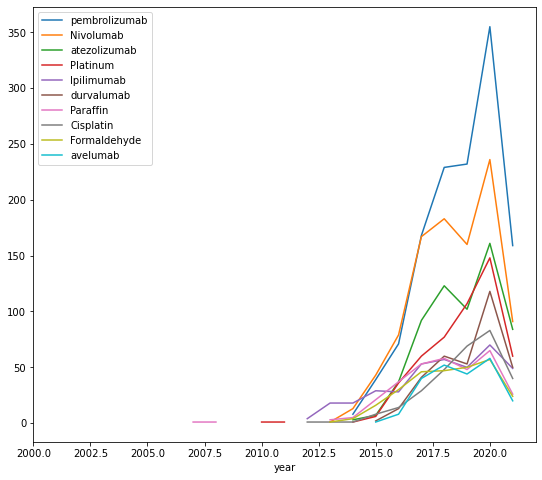

,id,name,0
0,MSHC:C582435,pembrolizumab,1261
1,MSHD:D000077594,Nivolumab,973
2,MSHC:C000594389,atezolizumab,609
3,MSHD:D010984,Platinum,498
4,MSHD:D000074324,Ipilimumab,377
5,MSHC:C000613593,durvalumab,337
6,MSHD:D010232,Paraffin,320
7,MSHD:D002945,Cisplatin,295
8,MSHD:D005557,Formaldehyde,276
9,MSHC:C000609138,avelumab,223


In [5]:
#select index, draw graph
add_index = 0
total_chemical_count = total_year_count['year']
for i in range(add_index, add_index + 10):
    chemical_count_some = chemical_count[chemical_count['id'] == chemical_count_df['id'][i]]
    chemical_count_some = chemical_count_some.drop(['id', 'name'], axis=1)
    chemical_count_some.columns = ['year', chemical_count_df['name'][i]]
    total_chemical_count = pd.merge(total_chemical_count, chemical_count_some, on='year', how='left')
total_chemical_count.plot(x='year', y=list(chemical_count_df['name'][add_index: add_index + 10]), figsize=(9,8))
plt.show()
chemical_count_df[add_index: add_index + 10]

In [6]:
#Delete chemical data by index
chemical_count_df = chemical_count_df.drop([0, 1]).reset_index(drop=True)
chemical_count_df

,id,name,0
0,MSHC:C000594389,atezolizumab,609
1,MSHD:D010984,Platinum,498
2,MSHD:D000074324,Ipilimumab,377
3,MSHC:C000613593,durvalumab,337
4,MSHD:D010232,Paraffin,320
...,...,...,...
1381,MSHC:C492546,GW280264X,1
1382,MSHC:C492908,"2-amino-3-(4'-N,N-bis(2-chloroethyl)amino)phen...",1
1383,MSHC:C493484,oligochitosan,1
1384,MSHC:C494219,Lewis a oligosaccharide,1


## 3. Graph of disease count by year

In [7]:
#load disease count dataframe
disease_count = pd.read_csv('../data/' + keyword + '_disease.csv')
disease_count_df = disease_count.drop(['year'], axis=1)
disease_count_df = disease_count_df.groupby(['id', 'name']).sum().sort_values(by=['0'], ascending=False).reset_index()

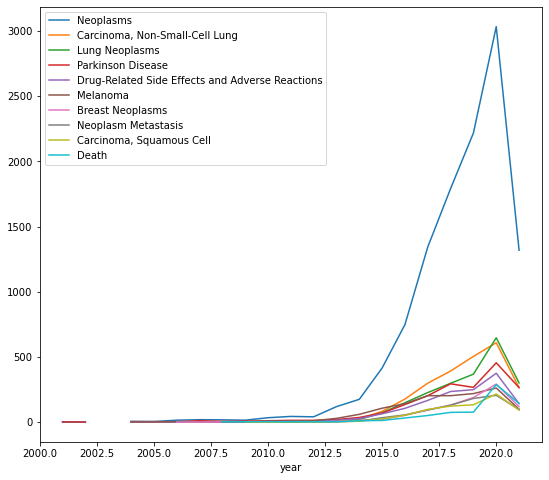

,id,name,0
0,MSHD:D009369,Neoplasms,11358
1,MSHD:D002289,"Carcinoma, Non-Small-Cell Lung",2374
2,MSHD:D008175,Lung Neoplasms,2109
3,MSHD:D010300,Parkinson Disease,1823
4,MSHD:D064420,Drug-Related Side Effects and Adverse Reactions,1410
5,MSHD:D008545,Melanoma,1361
6,MSHD:D001943,Breast Neoplasms,926
7,MSHD:D009362,Neoplasm Metastasis,823
8,MSHD:D002294,"Carcinoma, Squamous Cell",757
9,MSHD:D003643,Death,710


In [8]:
#select index, draw graph
add_index = 0
total_disease_count = total_year_count['year']
for i in range(add_index, add_index + 10):
    disease_count_some = disease_count[disease_count['id'] == disease_count_df['id'][i]]
    disease_count_some = disease_count_some.drop(['id', 'name'], axis=1)
    disease_count_some.columns = ['year', disease_count_df['name'][i]]
    total_disease_count = pd.merge(total_disease_count, disease_count_some, on='year', how='left')
total_disease_count.plot(x='year', y=list(disease_count_df['name'][add_index: add_index + 10]), figsize=(9,8))
plt.show()
disease_count_df[add_index: add_index + 10]

In [9]:
#Delete disease data by index
disease_count_df = disease_count_df.drop([0, 1]).reset_index(drop=True)
disease_count_df

,id,name,0
0,MSHD:D008175,Lung Neoplasms,2109
1,MSHD:D010300,Parkinson Disease,1823
2,MSHD:D064420,Drug-Related Side Effects and Adverse Reactions,1410
3,MSHD:D008545,Melanoma,1361
4,MSHD:D001943,Breast Neoplasms,926
...,...,...,...
1770,MSHD:D007003,Hypoglycemia,1
1771,MSHD:D007019,Hypoproteinemia,1
1772,MSHD:D007027,Hypothalamic Diseases,1
1773,MSHD:D007040,Hypoventilation,1


## 4. Graph of gene count by year

In [10]:
#load gene count dataframe
gene_count = pd.read_csv('../data/' + keyword + '_gene.csv')
gene_count_df = gene_count.drop(['year'], axis=1)
gene_count_df = gene_count_df.groupby(['id', 'name']).sum().sort_values(by=['0'], ascending=False).reset_index()

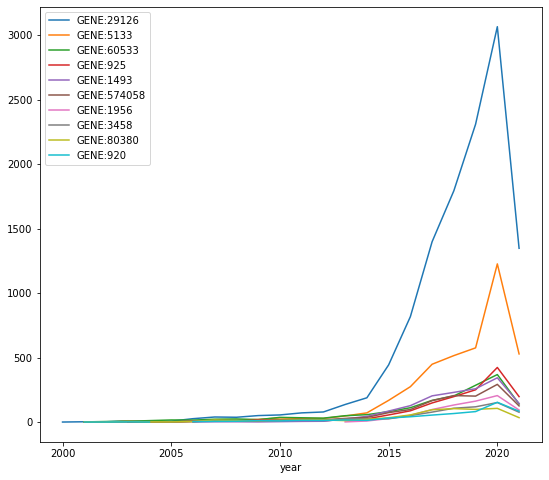

,id,name,0
0,GENE:29126,PD-L1,11900
1,GENE:5133,PD-1,4025
2,GENE:60533,PD-L1,1699
3,GENE:925,CD8,1503
4,GENE:1493,cytotoxic T-lymphocyte associated protein 4,1498
5,GENE:574058,PD-L1,1336
6,GENE:1956,EGFR,787
7,GENE:3458,IFN-gamma,758
8,GENE:80380,PD-L2,672
9,GENE:920,CD4,619


In [11]:
#select index, draw graph
add_index = 0
total_gene_count = total_year_count['year']
for i in range(add_index, add_index + 10):
    gene_count_some = gene_count[gene_count['id'] == gene_count_df['id'][i]]
    gene_count_some = gene_count_some.drop(['id', 'name'], axis=1)
    gene_count_some.columns = ['year', gene_count_df['id'][i]]
    total_gene_count = pd.merge(total_gene_count, gene_count_some, on='year', how='left')
total_gene_count.plot(x='year', y=list(gene_count_df['id'][add_index: add_index + 10]), figsize=(9,8))
plt.show()
gene_count_df[add_index: add_index + 10]

In [12]:
#Delete gene data by index
gene_count_df = gene_count_df.drop([0]).reset_index(drop=True)
gene_count_df

,id,name,0
0,GENE:5133,PD-1,4025
1,GENE:60533,PD-L1,1699
2,GENE:925,CD8,1503
3,GENE:1493,cytotoxic T-lymphocyte associated protein 4,1498
4,GENE:574058,PD-L1,1336
...,...,...,...
4078,GENE:14011,TEL,1
4079,GENE:397260,SMAD3,1
4080,GENE:397261,STAT4,1
4081,GENE:1398,Crk,1


## 5. graph of target count yearly

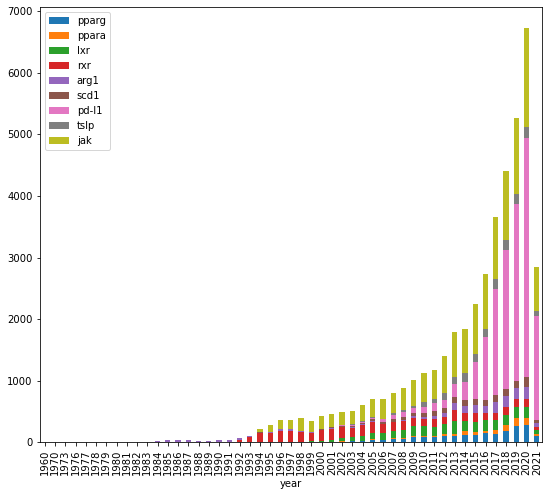

,index,year,pparg,ppara,lxr,rxr,arg1,scd1,pd-l1,tslp,jak
0,47,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,48,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,32,1973,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,33,1976,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,1.0
4,34,1977,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
5,35,1978,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
6,36,1979,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
7,37,1980,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
8,38,1981,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
9,39,1982,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN


In [13]:
total_year_count.plot(x='year', y=targets, kind='bar', stacked=True, figsize=(9,8))
plt.show()
total_year_count

#### OBSOLETE mesh data

MSHC:C562729	MSHC:C536915	MSHC:C076029	MSHC:C060836	MSHC:C089730	MSHC:C015329	MSHC:C108606
MSHC:C057693	MSHC:C084178	MSHC:C102006	MSHC:C097613	MSHC:C111237	MSHC:C094645	MSHC:C067134
MSHC:C059514	MSHD:D013749	MSHC:C552334	MSHC:C040029	MSHC:C471405	MSHC:C055512	MSHC:C064276
MSHC:C440975	MSHC:C095105	MSHC:C089032	MSHC:C029743	MSHC:C012629	MSHC:C105934	MSHC:C551994
MSHC:C103303	MSHC:C009250	MSHC:C055122	MSHC:C030852	MSHC:C030110	MSHC:C058218	MSHC:C473478
MSHC:C475919	MSHC:C093400	MSHC:C067311	MSHC:C047246	MSHC:C000603933	MSHC:C535575	MSHC:C538231
MSHC:C535533	MSHC:C538616	MSHC:C538339	MSHC:C406061	MSHC:C014347	MSHC:C550911	MSHC:C522924
MSHC:C419708	MSHC:C551177	MSHC:C561093	MSHC:C068329	MSHC:C503983	MSHC:C400082	MSHC:C467567
MSHC:C101426	MSHC:C049947	MSHC:C063008	MSHC:C098350	MSHC:C400278	MSHC:C488369	MSHC:C051890
MSHC:C043435	MSHC:C110904	MSHC:C503223	MSHC:C074921	MSHC:C536572	MSHC:C001758	MSHC:C045463
MSHC:C089995	MSHC:C535011	MSHC:C104727	MSHC:C006632	MSHC:C009687

https://id.nlm.nih.gov/mesh/C562729.html